---
title: "Exploratory Data Analysis"
format:
    html: 
        code-fold: false
---

<!-- After digesting the instructions, you can delete this cell, these are assignment instructions and do not need to be included in your final submission.  -->

{{< include instructions.qmd >}} 

# Code 

Provide the source code used for this section of the project here.

If you're using a package for code organization, you can import it at this point. However, make sure that the **actual workflow steps**—including data processing, analysis, and other key tasks—are conducted and clearly demonstrated on this page. The goal is to show the technical flow of your project, highlighting how the code is executed to achieve your results.

If relevant, link to additional documentation or external references that explain any complex components. This section should give readers a clear view of how the project is implemented from a technical perspective.

Remember, this page is a technical narrative, NOT just a notebook with a collection of code cells, include in-line Prose, to describe what is going on.

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
# Load the CSV file
file_path = '../../data/processed-data/merged_data.csv'
data = pd.read_csv(file_path)

## Univariate Analysis for Gender-Related Data

### Univariate Analysis for Total Score

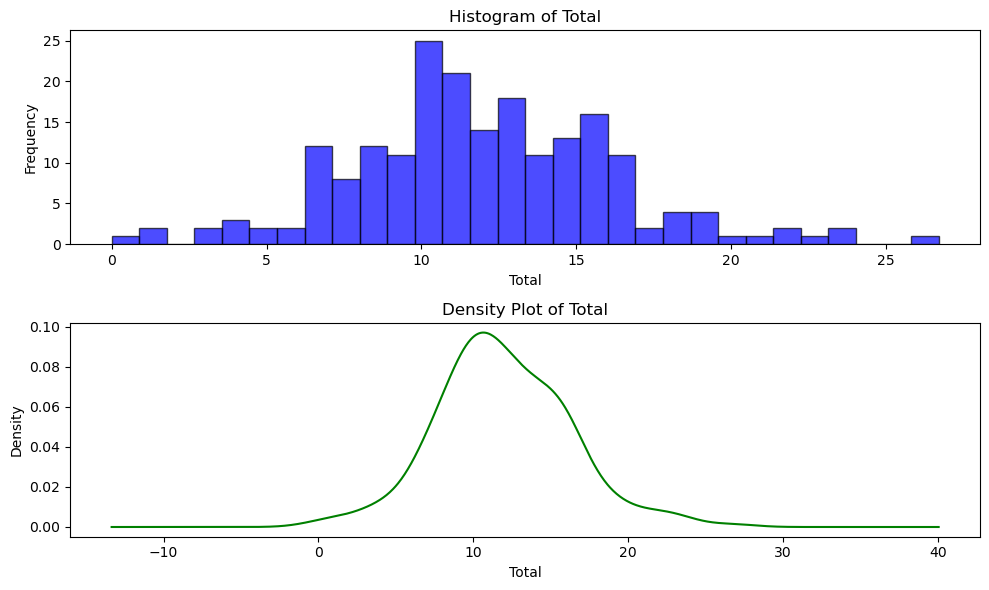

count    202.000000
mean      11.930198
std        4.258177
min        0.000000
25%        9.400000
50%       11.550000
75%       14.700000
max       26.700000
Name: Total, dtype: float64

In [13]:
# Filter for the "Total" column and ensure it is numeric
data['Total'] = pd.to_numeric(data['Total'], errors='coerce')

# Calculate summary statistics for "Total"
summary_stats = data['Total'].describe()

# Visualize distribution using histograms and density plots
plt.figure(figsize=(10, 6))

# Histogram
plt.subplot(2, 1, 1)
plt.hist(data['Total'].dropna(), bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title('Histogram of Total')
plt.xlabel('Total')
plt.ylabel('Frequency')

# Density Plot
plt.subplot(2, 1, 2)
data['Total'].dropna().plot(kind='density', color='green')
plt.title('Density Plot of Total')
plt.xlabel('Total')

plt.tight_layout()
plt.show()

summary_stats

The maximum possible Total Score is 100, representing the highest performance in terms of gender equality and respect. This includes aspects such as working environment, compensation and benefits, and the prevention of violence and harassment.

**Statistical Summary**:
1. Count: 202 companies are included in the dataset.
2. Mean: The average Total Score is 11.93, which is far below from the maximum possible score of 100.
3. Standard Deviation: The scores have a spread of 4.26, indicating moderate variability in performance.
4. Minimum: The lowest score is 0, suggesting that some companies performed extremely poorly in gender equality measures.
5. Maximum: The highest score in the dataset is 26.70, far below the theoretical maximum of 100, which highlights the overall poor performance.

**Visual Observations**:
1. Histogram: The majority of the scores are clustered around the 10-15 range, with the frequency peaking near the mean (11.93). Very few companies scored above 20, indicating that achieving high scores is uncommon in this dataset.
2. Density Plot: The density curve is slightly skewed to the right, with a long tail extending towards higher scores, highlighting a few outliers with better performance. The peak of the density aligns closely with the mean and median, reinforcing the clustering of scores in the mid-range.

**Key Insights**:

The low mean, median, and maximum values underscore that most companies in the dataset are performing poorly on gender equality and respect indicators. There is a significant opportunity for improvement, as no company has achieved scores close to the theoretical maximum.

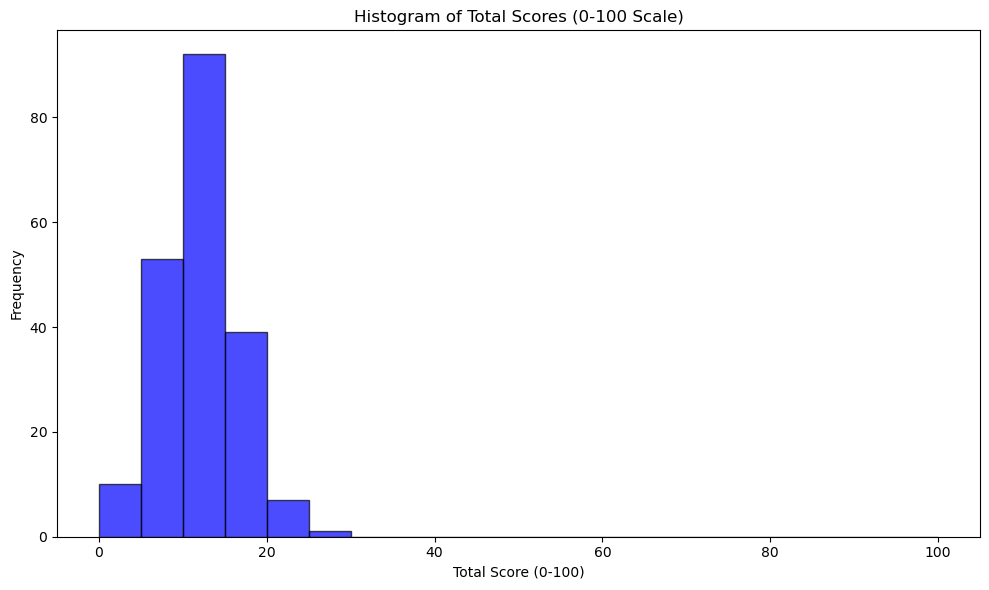

In [14]:
# Histogram with the scale set to 0-100
plt.figure(figsize=(10, 6))

# Histogram with fixed range 0-100
plt.hist(data['Total'].dropna(), bins=20, range=(0, 100), alpha=0.7, color='blue', edgecolor='black')
plt.title('Histogram of Total Scores (0-100 Scale)')
plt.xlabel('Total Score (0-100)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


When we put the data into a scale of 0-100 (the theoritical scale), we can see the overall performance of the companies in a more clear way:

**Visual Observations**:
1. Data Concentration: The majority of the Total Scores fall well below the midpoint of the 0-100 scale, with most scores concentrated between 0 and 30.
2. Lack of High Scores: No data points exceed a score of 30 out of 100, indicating that companies in the dataset perform significantly below the potential benchmark.

**Key Insights**:

The visualization starkly highlights the underperformance of these companies in meeting gender equality standards. This may point to systemic issues or a lack of substantial initiatives toward achieving higher scores.

### Univariate Analysis for CEO Gender

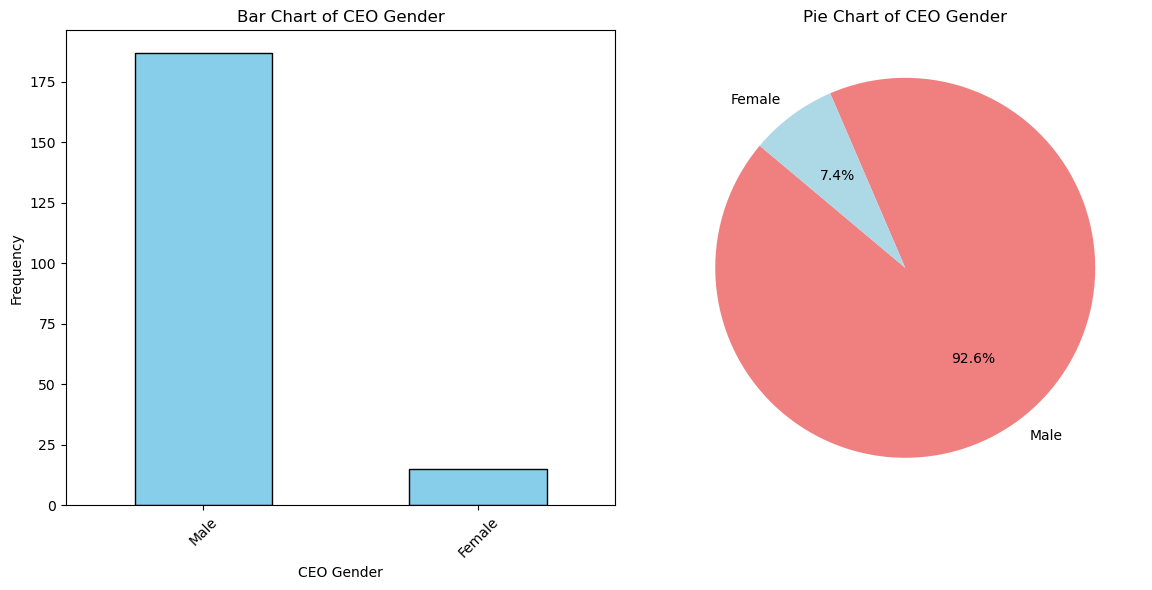

CEO Gender
Male      187
Female     15
Name: count, dtype: int64

In [15]:
# Frequency counts for "CEO Gender"
ceo_gender_counts = data['CEO Gender'].value_counts()

# Visualizing the distribution using bar chart and pie chart
plt.figure(figsize=(12, 6))

# Bar Chart
plt.subplot(1, 2, 1)
ceo_gender_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Bar Chart of CEO Gender')
plt.xlabel('CEO Gender')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

# Pie Chart
plt.subplot(1, 2, 2)
ceo_gender_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=['lightcoral', 'lightblue', 'lightgreen'])
plt.title('Pie Chart of CEO Gender')
plt.ylabel('')  # Removing the y-label for a cleaner pie chart

plt.tight_layout()
plt.show()

ceo_gender_counts

The data reveals a significant imbalance in CEO gender representation:

**Visual Observations**:

The majority of CEOs in the dataset are male (92.6%), while only a small percentage (7.4%) are female. The bar and pie charts both illustrate this stark gender gap, emphasizing the dominance of male CEOs across companies.

**Key Insights**:

This disparity showed in the charts highlights a clear underrepresentation of women in top leadership positions. Coupled with the low Total Scores observed for gender equality indicators, it is evident that most companies are underperforming in fostering a more equitable and inclusive environment. This imbalance underscores the need for stronger initiatives and actionable commitments to promote gender diversity at the leadership level.

## Bivariate and Multivariate Analysis

### Relationships Between Financial Indicators and Total Score

First, we use Assets to standardize the financial indicators (except for EarningsPerShareBasic, since it is already a ratio rather than an amount), ensuring they are not influenced by company size in the subsequent analysis.

In [17]:
# Standardizing financial indicators by total assets
financial_columns = [
    'NetIncomeLoss (k)', 
    'OperatingIncomeLoss (k)', 
    'GrossProfit (k)', 
    'ComprehensiveIncomeNetOfTax (k)', 
    'RevenueFromContractWithCustomerExcludingAssessedTax (k)', 
    'EntityPublicFloat (k)', 
    'AllocatedShareBasedCompensationExpense (k)', 
    'CashAndCashEquivalentsAtCarryingValue (k)', 
    'AccountsReceivableNetCurrent (k)'
]

data['Assets (k)'] = pd.to_numeric(data['Assets (k)'], errors='coerce')

# Avoid division by zero or null assets
data['Assets (k)'] = data['Assets (k)'].replace(0, pd.NA)

# Standardize each financial column by Total Assets
for col in financial_columns:
    standardized_col = f"{col}_PerAssets"
    data[standardized_col] = data[col] / data['Assets (k)']

# Display the standardized columns for review
data[[f"{col}_PerAssets" for col in financial_columns]].head()

,NetIncomeLoss (k)_PerAssets,OperatingIncomeLoss (k)_PerAssets,GrossProfit (k)_PerAssets,ComprehensiveIncomeNetOfTax (k)_PerAssets,RevenueFromContractWithCustomerExcludingAssessedTax (k)_PerAssets,EntityPublicFloat (k)_PerAssets,AllocatedShareBasedCompensationExpense (k)_PerAssets,CashAndCashEquivalentsAtCarryingValue (k)_PerAssets,AccountsReceivableNetCurrent (k)_PerAssets
0,0.141692,0.182959,0.328574,0.161306,0.543072,3.671740,NaN,0.180449,0.127569
1,-4.370164,-7.375983,NaN,-4.391481,0.367819,0.626670,0.001002,0.010744,0.055107
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.025766,NaN,NaN,0.041853,0.354137,1.733026,0.003549,0.114589,NaN
4,0.127129,0.088929,0.192701,0.144526,0.933090,0.549736,0.003650,0.079562,NaN


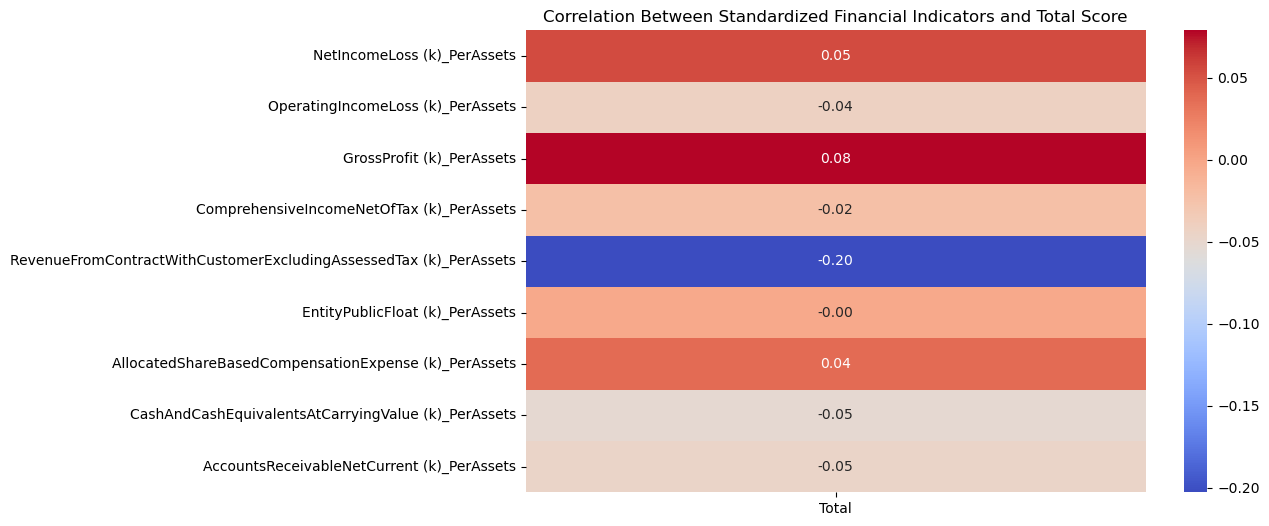

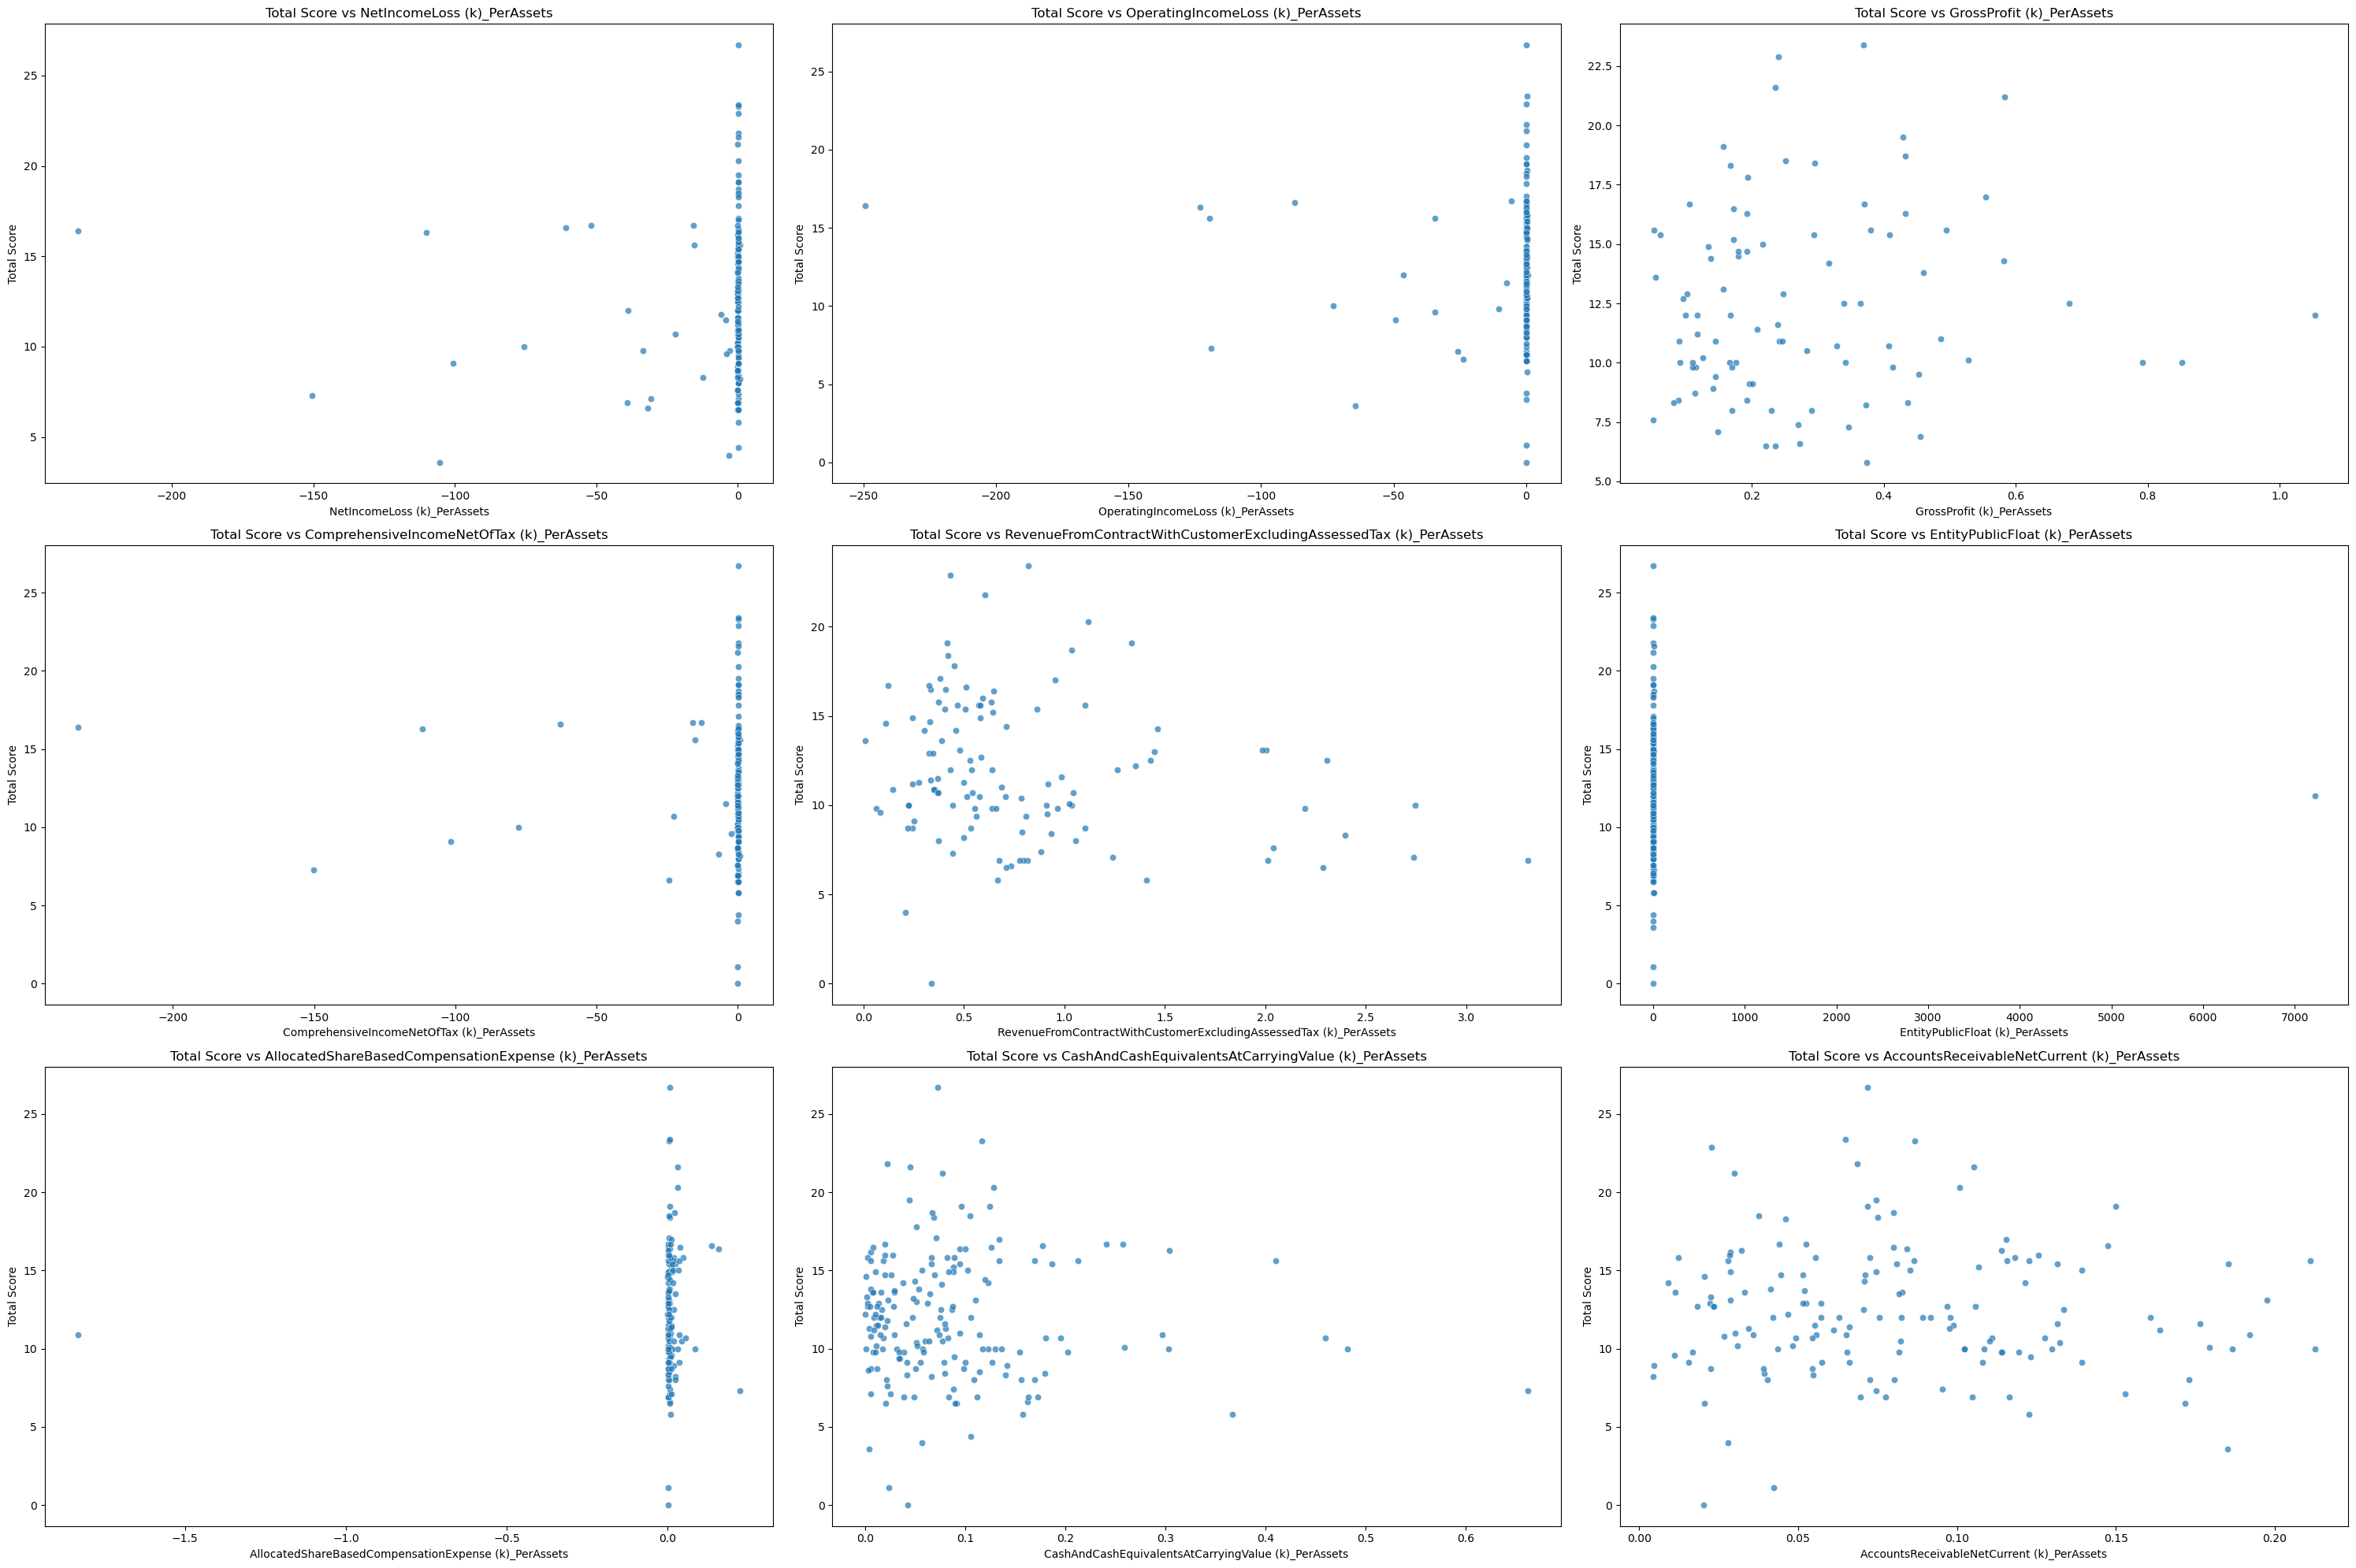

In [20]:
# List of standardized financial indicator columns
standardized_columns = [f"{col}_PerAssets" for col in financial_columns]

# Correlation Analysis
# Compute correlations between standardized financial indicators and Total Score
correlation_data = data[standardized_columns + ['Total']].corr()
correlations = correlation_data['Total'].drop('Total')

# Visualize correlations using a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlations.to_frame(), annot=True, cmap='coolwarm', cbar=True, fmt=".2f")
plt.title("Correlation Between Standardized Financial Indicators and Total Score")
plt.show()

# Feature Pairings: Scatter plots for each financial indicator vs Total Score
plt.figure(figsize=(30, 20))
for i, col in enumerate(standardized_columns, start=1):
    plt.subplot(3, 3, i)
    sns.scatterplot(x=data[col], y=data['Total'], alpha=0.7)
    plt.title(f"Total Score vs {col}")
    plt.xlabel(col)
    plt.ylabel("Total Score")

plt.tight_layout()
plt.show()

### Differences in Financial Indicator Means by CEO Gender